In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

sns.set_style("darkgrid")
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

# pprevent annoying tensorflow warning
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings

warnings.simplefilter("ignore")

In [ ]:
import pathlib
sdir = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits"
bad_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits"
good_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits"
mixed_path = r"../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
filepaths = []
labels = []
ht = 0
wt = 0
samples = 0
sample_count = 20
for quality in [bad_path, good_path, mixed_path]:
    fruit_list = os.listdir(quality)
    for fruit in fruit_list:
        fruit_path = os.path.join(quality, fruit)
        img_list = os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path = os.path.join(fruit_path, img)
            if i < sample_count:
                img = plt.imread(img_path)
                ht += img.shape[0]
                wt += img.shape[1]
                samples += 1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + "_mixed")
            else:
                labels.append(fruit)
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)
df 

In [ ]:
df['labels']=df['labels'].astype('category')

In [165]:
df['labels'].value_counts()

Pomegranate_Good     5940
Orange_Good          1216
Pomegranate_Bad      1187
Orange_Bad           1159
Guava_Good           1152
Apple_Good           1149
Apple_Bad            1141
Guava_Bad            1129
Banana_Good          1113
Lime_Good            1094
Banana_Bad           1087
Lime_Bad             1085
Banana_mixed          285
Lemon_mixed           278
Guava_mixed           148
Orange_mixed          125
Pomegranate_mixed     125
Apple_mixed           113
Name: labels, dtype: int64

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

df['labels'].unique()

['Guava_Bad', 'Lime_Bad', 'Orange_Bad', 'Pomegranate_Bad', 'Banana_Bad', ..., 'Pomegranate_mixed', 'Apple_mixed', 'Guava_mixed', 'Lemon_mixed', 'Banana_mixed']
Length: 18
Categories (18, object): ['Apple_Bad', 'Apple_Good', 'Apple_mixed', 'Banana_Bad', ..., 'Orange_mixed', 'Pomegranate_Bad', 'Pomegranate_Good', 'Pomegranate_mixed']

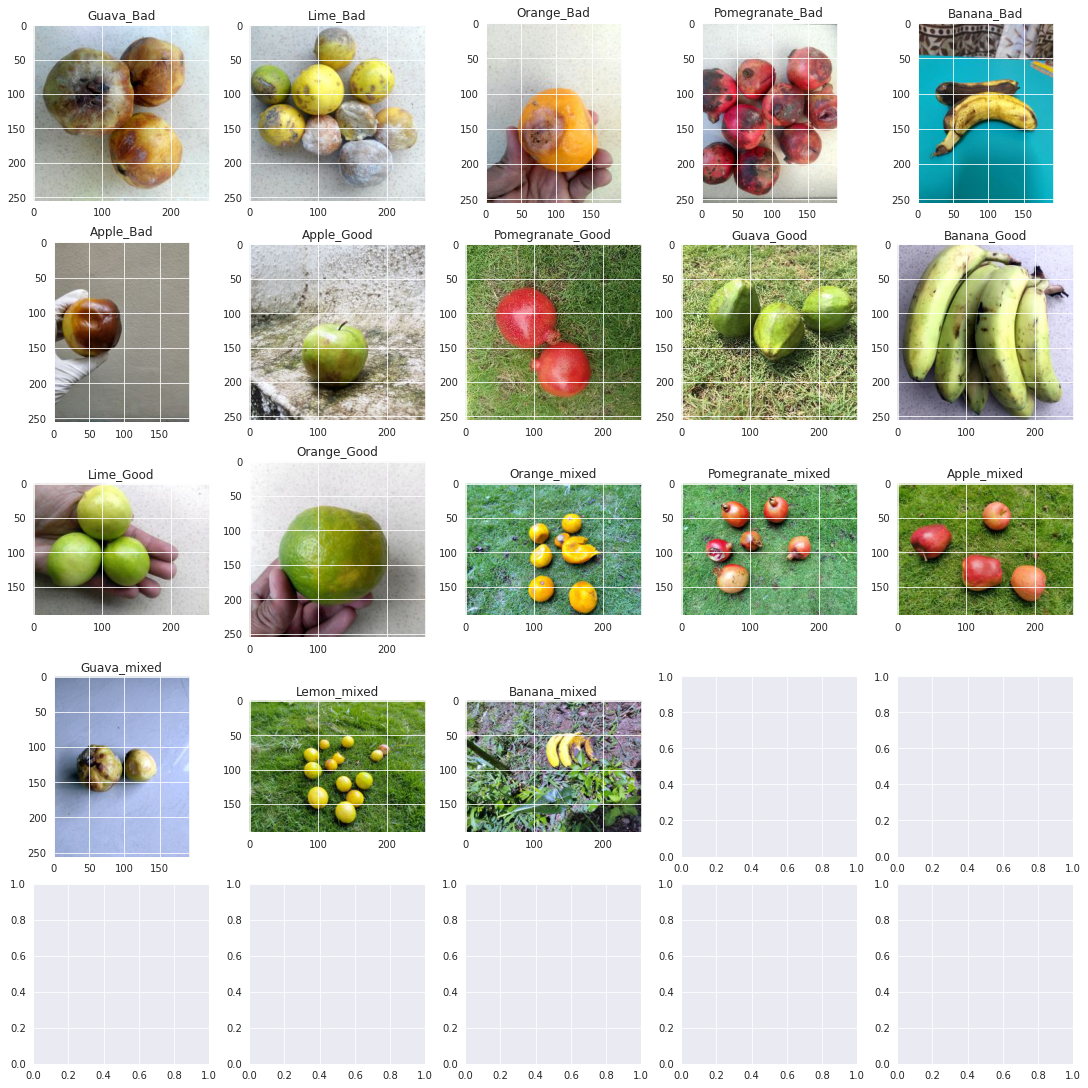

In [167]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,15), constrained_layout=True)
ax=ax.flatten()
j=0
for i in df['labels'].unique():
    
    ax[j].imshow(plt.imread(df[df['labels']==i].iloc[0,0]))
    ax[j].set_title(i)
    j=j+1

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test=train_test_split(df, test_size=0.2, random_state=123)

In [169]:
print(X_train.shape)
print(X_test.shape)

(15620, 2)
(3906, 2)


In [170]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainGen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                              validation_split=0.2)
testGen =ImageDataGenerator(preprocessing_function= preprocess_input)
X_train_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                           x_col='filepaths', 
                                           y_col='labels',
                                           class_mode='categorical', 
                                           subset='training', 
                                           batch_size=32)
X_val_img = trainGen.flow_from_dataframe(dataframe=X_train, 
                                         x_col='filepaths', 
                                         y_col='labels',
                                         class_mode='categorical', 
                                         subset='validation',
                                         batch_size=32)
X_test_img =testGen.flow_from_dataframe(dataframe=X_test, 
                                        x_col='filepaths', 
                                        y_col='labels',
                                        class_mode='categorical', 
                                        batch_size=32, 
                                        shuffle=False)

Found 12496 validated image filenames belonging to 18 classes.
Found 3124 validated image filenames belonging to 18 classes.
Found 3906 validated image filenames belonging to 18 classes.


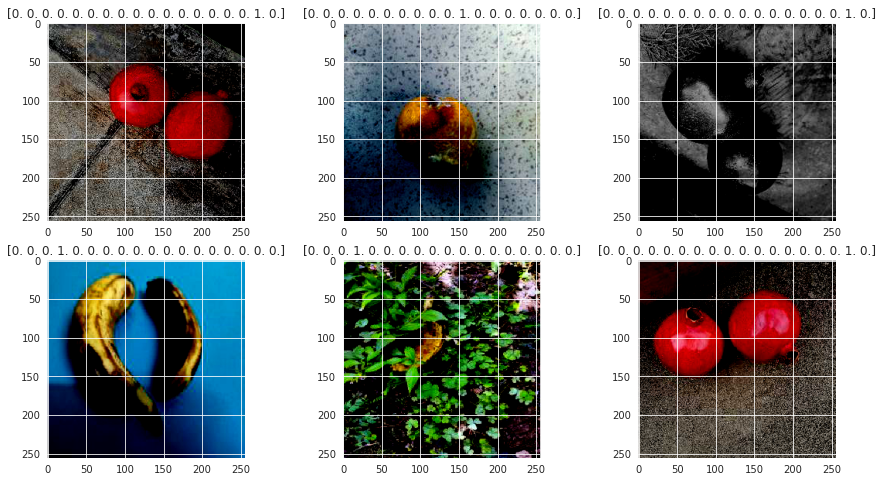

In [171]:
fit, ax= plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
j=0
for _ in range(6):
    img, label = X_test_img.next()
    #print(img.shape)   #  (1,256,256,3)
    ax[j].imshow(img[0],)
    ax[j].set_title(label[0])
    #plt.show()
    j=j+1

In [172]:
X_test_img[0][0].shape

(32, 256, 256, 3)

In [173]:
image_shape=(256,256,3)

In [174]:
X_train_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [175]:
X_val_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [176]:
X_test_img.class_indices

{'Apple_Bad': 0,
 'Apple_Good': 1,
 'Apple_mixed': 2,
 'Banana_Bad': 3,
 'Banana_Good': 4,
 'Banana_mixed': 5,
 'Guava_Bad': 6,
 'Guava_Good': 7,
 'Guava_mixed': 8,
 'Lemon_mixed': 9,
 'Lime_Bad': 10,
 'Lime_Good': 11,
 'Orange_Bad': 12,
 'Orange_Good': 13,
 'Orange_mixed': 14,
 'Pomegranate_Bad': 15,
 'Pomegranate_Good': 16,
 'Pomegranate_mixed': 17}

In [177]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [178]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
pre_trained= InceptionResNetV2(include_top=False, input_shape=image_shape)

#for layers in pre_trained.layers:
#    layers.trainable=False
pre_trained.trainable=False

inputs = pre_trained.input
x = data_augmentation(inputs)
x = pre_trained(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output=Dense(18, activation='softmax')(x)
model = Model(inputs=inputs, outputs=output)



base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=['accuracy'])

In [179]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_21  (None, 1536)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 18)                27666     
Total params: 54,364,402
Trainable params: 27,666
Non-trainable params: 54,336,736
__________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)

initial_epoch = 10
results = model.fit(X_train_img,epochs= initial_epoch,
                              validation_data=X_val_img,
                                callbacks=[early_stop])

Epoch 1/10


2022-11-24 08:30:41.048019: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


391/391 [==============================] - 277s 657ms/step - loss: 1.7359 - accuracy: 0.4910 - val_loss: 1.0373 - val_accuracy: 0.7081
Epoch 2/10
391/391 [==============================] - 245s 627ms/step - loss: 1.0094 - accuracy: 0.7045 - val_loss: 0.7477 - val_accuracy: 0.7939
Epoch 3/10
391/391 [==============================] - 250s 641ms/step - loss: 0.7879 - accuracy: 0.7638 - val_loss: 0.6228 - val_accuracy: 0.8255
Epoch 4/10
391/391 [==============================] - 249s 636ms/step - loss: 0.6595 - accuracy: 0.8039 - val_loss: 0.5536 - val_accuracy: 0.8473
Epoch 5/10
391/391 [==============================] - 246s 629ms/step - loss: 0.5983 - accuracy: 0.8190 - val_loss: 0.4987 - val_accuracy: 0.8560
Epoch 6/10
391/391 [==============================] - 246s 630ms/step - loss: 0.5484 - accuracy: 0.8342 - val_loss: 0.4579 - val_accuracy: 0.8659
Epoch 7/10
391/391 [==============================] - 246s 628ms/step - loss: 0.5017 - accuracy: 0.8476 - val_loss: 0.4308 - val_accura

Text(0.5, 1.0, 'Loss')

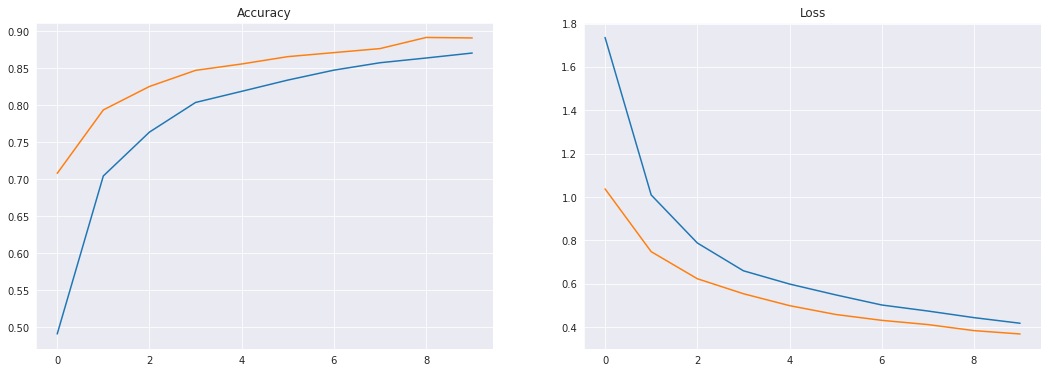

In [193]:

result_df = pd.DataFrame(results.history)
fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax=ax.flatten()
ax[0].plot(result_df[['accuracy','val_accuracy']])
ax[0].set_title("Accuracy")
ax[1].plot(result_df[['loss','val_loss']])
ax[1].set_title("Loss")

In [182]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

In [183]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.8914490527393754


<AxesSubplot:>

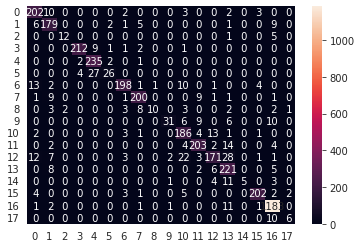

In [184]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

                                               filepaths            labels  \
8323   ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
4204   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
16867  ../input/fruitnet-indian-fruits-dataset-with-q...         Lime_Good   
4413   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
12590  ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
14868  ../input/fruitnet-indian-fruits-dataset-with-q...        Guava_Good   

                   pred  
8323   Pomegranate_Good  
4204    Pomegranate_Bad  
16867         Lime_Good  
4413    Pomegranate_Bad  
12590  Pomegranate_Good  
14868        Guava_Good  


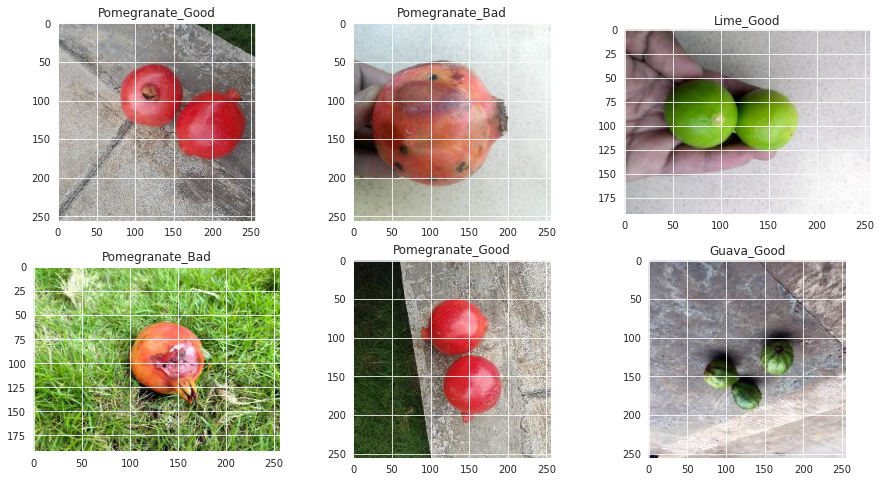

In [185]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(6))
fig, ax=plt.subplots(nrows=2, ncols=3, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(6).reset_index()
for i in range(0,6):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])

Fine Tuning

In [186]:
pre_trained.trainable = True

In [187]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [188]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [189]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_21  (None, 1536)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 18)                27666     
Total params: 54,364,402
Trainable params: 53,536,290
Non-trainable params: 828,112
_________________________________________

In [190]:
len(model.trainable_variables)

426

In [191]:
fine_tune_epochs = 10
total_epochs =  initial_epoch + fine_tune_epochs

history_fine = model.fit(X_train_img,
                         epochs=total_epochs,
                         initial_epoch=10,
                         validation_data=X_val_img)

Epoch 11/20
391/391 [==============================] - 411s 977ms/step - loss: 0.1733 - accuracy: 0.9433 - val_loss: 0.0777 - val_accuracy: 0.9728
Epoch 12/20
391/391 [==============================] - 378s 967ms/step - loss: 0.0633 - accuracy: 0.9779 - val_loss: 0.0399 - val_accuracy: 0.9894
Epoch 13/20
391/391 [==============================] - 379s 969ms/step - loss: 0.0362 - accuracy: 0.9871 - val_loss: 0.0306 - val_accuracy: 0.9917
Epoch 14/20
391/391 [==============================] - 372s 952ms/step - loss: 0.0272 - accuracy: 0.9910 - val_loss: 0.0279 - val_accuracy: 0.9933
Epoch 15/20
391/391 [==============================] - 376s 962ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0323 - val_accuracy: 0.9933
Epoch 16/20
391/391 [==============================] - 376s 961ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0260 - val_accuracy: 0.9930
Epoch 17/20
391/391 [==============================] - 376s 961ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0

In [194]:
acc = results.history['accuracy']
val_acc = results.history['val_accuracy']

loss = results.history['loss']
val_loss = results.history['val_loss']

# result_df = pd.DataFrame(results.history)
# fig, ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
# ax=ax.flatten()
# ax[0].plot(result_df[['accuracy','val_accuracy']])
# ax[0].set_title("Accuracy")
# ax[1].plot(result_df[['loss','val_loss']])
# ax[1].set_title("Loss")

In [195]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

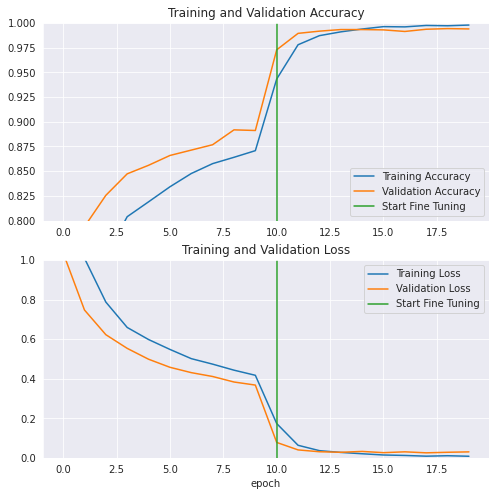

In [199]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10,10],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10,10],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [200]:
model.save("fruitNet.h5")

In [208]:
loss, accuracy = model.evaluate(X_test_img)
print('Test accuracy :', accuracy)

123/123 [==============================] - 61s 497ms/step - loss: 0.0242 - accuracy: 0.9944
Test accuracy : 0.9943676590919495


In [201]:
pred = model.predict(X_test_img)
pred=np.argmax(pred,axis=1)

In [203]:
pred_df=X_test.copy()
labels={}
for l,v in X_test_img.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

Accuracy Score: 0.9943676395289298


<AxesSubplot:>

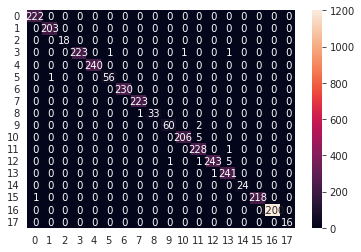

In [204]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(f"Accuracy Score: {accuracy_score(pred_df['labels'],pred_df['pred'])}")
sns.heatmap(confusion_matrix(pred_df['labels'],pred_df['pred']), annot=True, fmt='2d')

                                               filepaths            labels  \
8323   ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
4204   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
16867  ../input/fruitnet-indian-fruits-dataset-with-q...         Lime_Good   
4413   ../input/fruitnet-indian-fruits-dataset-with-q...   Pomegranate_Bad   
12590  ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
14868  ../input/fruitnet-indian-fruits-dataset-with-q...        Guava_Good   
12894  ../input/fruitnet-indian-fruits-dataset-with-q...  Pomegranate_Good   
4928   ../input/fruitnet-indian-fruits-dataset-with-q...        Banana_Bad   
2547   ../input/fruitnet-indian-fruits-dataset-with-q...        Orange_Bad   
6524   ../input/fruitnet-indian-fruits-dataset-with-q...         Apple_Bad   
16789  ../input/fruitnet-indian-fruits-dataset-with-q...         Lime_Good   
19321  ../input/fruitnet-indian-fruits-dataset-with-q...      Ba

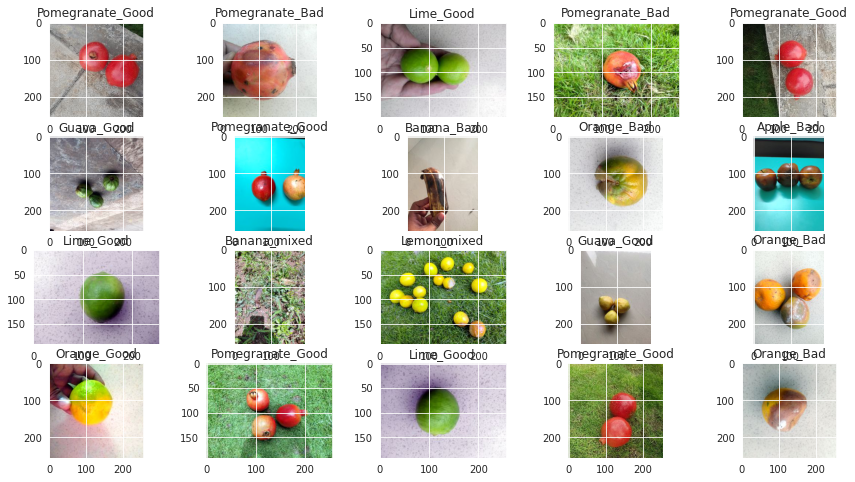

In [207]:
print(pred_df[pred_df['labels']==pred_df['pred']].head(20))
fig, ax=plt.subplots(nrows=4, ncols=5, figsize=(15,8))
ax=ax.flatten()
imlist=pred_df[pred_df['labels']==pred_df['pred']].head(20).reset_index()
for i in range(0,20):
    ax[i].imshow(plt.imread(imlist['filepaths'][i]))
    ax[i].set_title(imlist['labels'][i])